## Importing Libraries

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import pandas as pd
import re
from keras.preprocessing.text import text_to_word_sequence
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np


## Reading the dataset

In [2]:
imdb_df = pd.read_csv(r"C:\Users\liuru\Desktop\EE6405\Data\IMDB\IMDB Dataset.csv")

In [3]:
df_positive = imdb_df[imdb_df['sentiment']=='positive'][:5000]
df_negative = imdb_df[imdb_df['sentiment']=='negative'][:5000]
imdb = pd.concat([df_positive,df_negative ])

In [4]:
imdb.shape

(10000, 2)

## Preprocessing

Data before preprocessing

In [5]:
print(imdb['review'][3])

Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.


Preprocessing with regex to remove punctuation and special chars, lowercase

In [6]:
# remove "(<.*?>)" markup
imdb['review'] = imdb['review'].apply(lambda x: re.sub('(<.*?>)', ' ', x))
# remove punctuation marks 
imdb['review'] = imdb['review'].apply(lambda x: re.sub('[,\.!?:()"]', '', x))
# remove whitespace
imdb['review'] = imdb['review'].apply(lambda x: x.strip())
# remove all strings that contain a non-letter
imdb['review'] = imdb['review'].apply(lambda x: re.sub('[^a-zA-Z"]',' ',x))
# convert to lower
imdb['review'] = imdb['review'].apply(lambda x: x.lower())

POS Tagging + Lemmatizer

In [7]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('averaged_perceptron_tagger')
lemmatizer= WordNetLemmatizer()
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\liuru\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\liuru\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [8]:
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

In [9]:
def tagged_lemma(string):
    
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(string))

    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))

    lemmatized_sentence = []

    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:       
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    lemmatized_sentence = " ".join(lemmatized_sentence)
    return lemmatized_sentence

In [10]:
imdb['review']=imdb['review'].apply(tagged_lemma)

In [11]:
print(imdb['review'][3])

basically there s a family where a little boy jake think there s a zombie in his closet his parent be fight all the time this movie be slow than a soap opera and suddenly jake decides to become rambo and kill the zombie ok first of all when you re go to make a film you must decide if its a thriller or a drama as a drama the movie be watchable parent be divorce argue like in real life and then we have jake with his closet which totally ruin all the film i expect to see a boogeyman similar movie and instead i watch a drama with some meaningless thriller spot out of just for the well play parent descent dialog as for the shot with jake just ignore them


Remove Stop Words

In [12]:
words = imdb['review'].apply(lambda x: text_to_word_sequence(x))
stop_words = set(stopwords.words('english'))
filtered_words = words.apply(lambda x: [w for w in x if not w in stop_words])
imdb['review'] = filtered_words.apply(lambda x: " ".join(x))

In [13]:
imdb['review'][3]

'basically family little boy jake think zombie closet parent fight time movie slow soap opera suddenly jake decides become rambo kill zombie ok first go make film must decide thriller drama drama movie watchable parent divorce argue like real life jake closet totally ruin film expect see boogeyman similar movie instead watch drama meaningless thriller spot well play parent descent dialog shot jake ignore'

In [14]:
imdb.sentiment = imdb.sentiment.apply(lambda x: 1 if x=='positive' else 0)

In [15]:
from sklearn.model_selection import train_test_split
train_review, test_review, train_sent, test_sent = train_test_split(imdb['review'], imdb['sentiment'], test_size=0.25, random_state=42)

In [16]:
print(train_review.head)

<bound method NDFrame.head of 9758    brother psychokinetic power yes really duel de...
8709    goodnight mister tom beautifully film beautifu...
3411    ok hell suppose mean halloween let call ok wit...
9644    honestly know legal illegal substance writer w...
2171    rent movie think go see horror movie however l...
                              ...                        
1501    yes bad act one thing mention bad scriptnot ba...
358     movie feature charlie spradling dancing strip ...
761     think summary say mtv ish answer classic candi...
1685    unbelievable fourth well second third third aw...
4497    long go movie understanding go contain histori...
Name: review, Length: 7500, dtype: object>


In [17]:
#Tfidf vectorizer
tv=TfidfVectorizer(stop_words='english')
#transformed train reviews
train_review_tfidf=np.asarray(tv.fit_transform(train_review).todense())
#transformed test reviews
test_review_tfidf=np.asarray(tv.transform(test_review).todense())
print('Tfidf_train:',train_review_tfidf.shape)
print('Tfidf_test:',test_review_tfidf.shape)

Tfidf_train: (7500, 42076)
Tfidf_test: (2500, 42076)


In [18]:
print(train_review_tfidf[3].shape)

(42076,)


## Classifiers

In [19]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
#generates a confusion matrix between hand labelled data and model predictions
def getConfMatrix(pred_data, actual):
    conf_mat = confusion_matrix(actual, pred_data, labels=[0,1]) 
    micro = f1_score(actual, pred_data, average='micro') 
    macro = f1_score(actual,pred_data, average='macro')
    sns.heatmap(conf_mat, annot = True, fmt=".0f", annot_kws={"size": 18})
    print('F1 Micro: '+ str(micro))
    print('F1 Macro: '+ str(macro))

Support Vector Machines

In [20]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='rbf') # RBF kernel

#Train the model using the training sets
clf.fit(train_review_tfidf, train_sent)

#Predict the response for test dataset
y_pred = clf.predict(test_review_tfidf)

F1 Micro: 0.872
F1 Macro: 0.8718995692623017


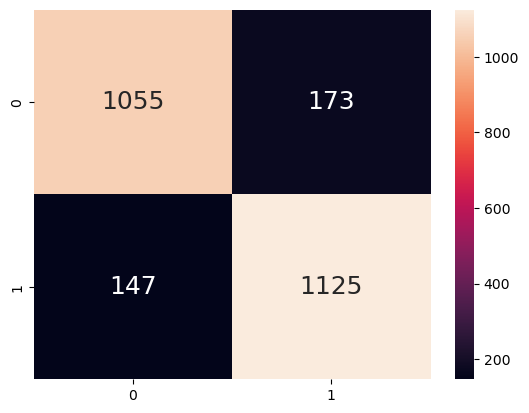

In [21]:
getConfMatrix(y_pred,test_sent)

Extreme Learning Machines

In [22]:
from skelm import ELMClassifier
clf = ELMClassifier()
#Train the model using the training sets
clf.fit(train_review_tfidf, train_sent)

#Predict the response for test dataset
y_pred = clf.predict(test_review_tfidf)


F1 Micro: 0.766
F1 Macro: 0.7659487334105661


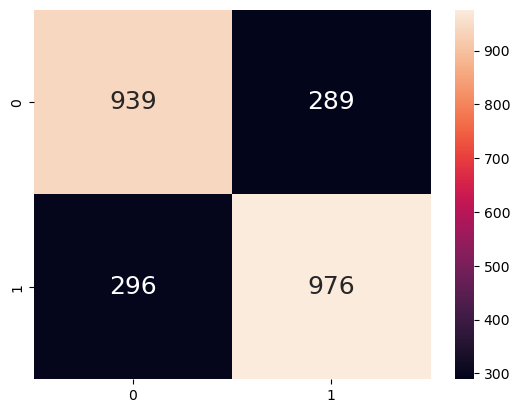

In [23]:
getConfMatrix(y_pred,test_sent)

Gaussian Process

In [24]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
kernel = 1.0 * RBF(1.0)
clf = GaussianProcessClassifier(kernel=kernel, random_state=0)
#Train the model using the training sets
clf.fit(train_review_tfidf, train_sent)

#Predict the response for test dataset
y_pred = clf.predict(test_review_tfidf)


F1 Micro: 0.8708
F1 Macro: 0.8707716938318169


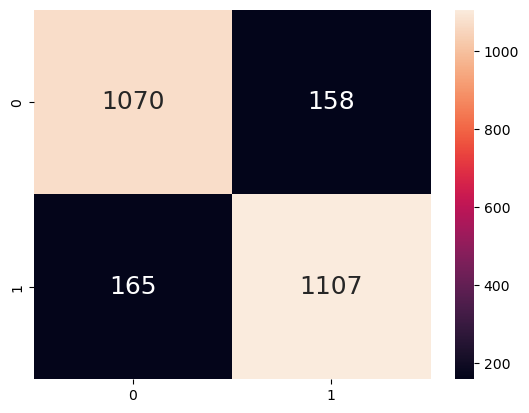

In [25]:
getConfMatrix(y_pred,test_sent)

KMeans Clustering

In [33]:
from sklearn.cluster import KMeans
for seed in range(5):
    kmeans = KMeans(
        n_clusters=2,
        max_iter=100,
        n_init=1,
        random_state=seed,
    ).fit(train_review_tfidf)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements assigned to each cluster: {cluster_sizes}")
print()


Number of elements assigned to each cluster: [5542 1958]
Number of elements assigned to each cluster: [2079 5421]
Number of elements assigned to each cluster: [2081 5419]
Number of elements assigned to each cluster: [5433 2067]
Number of elements assigned to each cluster: [2069 5431]



In [31]:
original_space_centroids = kmeans.cluster_centers_
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = tv.get_feature_names_out()

for i in range(2):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: movie bad good like watch make think really time film 
Cluster 1: film movie make like good time story character watch great 


In [38]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
train_review_lsa = lsa.fit_transform(train_review_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

Explained variance of the SVD step: 11.4%


In [43]:
kmeans = KMeans(
    n_clusters=2,
    max_iter=100,
    n_init=5,
    random_state=seed,
).fit(train_review_lsa)

In [44]:
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = tv.get_feature_names_out()

for i in range(2):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: movie bad good like watch make think time really film 
Cluster 1: film make like good time story character movie great watch 
